# Analysis of multiple stock tickers
---

In [22]:
# imports
from scraper import stock_daily
from analyzer import Analyzer
from IPython.display import display
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import indicators as ind

## Define ```test_strategy()```

Function ```test_strategy()``` analyses stock ticker using buy and sell strategy defined in the function body utilizing already written system scraping and analazying trades. 
<br><br>
Input: **ticker**: stock ticker, 4 letter string
<br>
Output: **result**: Pandas series in following order: ```ticker, trades, gtrades, profit[$], profit[%], hold[%]```

In [23]:
def test_strategy(ticker="None"):
    # create empy series
    result = {"ticker": ticker, "trades": np.nan, "gtrades": np.nan, "profit[$]": np.nan, "profit[%]": np.nan, "hold[%]": np.nan}
    result = pd.Series(data=result)
    # scraping / loading data
    try:
        stock = stock_daily(ticker, save=False)
    except:
        print(ticker + ": Exception occured during data scraping, skipped.")
        return result
    # creating analyzer instance
    trades = Analyzer(ticker=ticker, data=stock.data)
    
    # SETTINGS
    # stop loss
    sl = True
    slval = 0.06
    # profit taker
    pt = False
    ptval = 0.11
    # repeteated buys
    rb = False

    # STRATEGY DEFINITIONS
    # ================> Buy strategy: SVF
    # STRATEGY DEFINITIONS
    # calculating VFI
    vfi = ind.vfi(stock.data, period=30, coef=0.2, vcoef=1.5)
    fs = ind.stoch(stock.data, period=5, sk=2, sd=3)
    # calculating VFI histogram trend
    window = 3
    vfi_hist = vfi["histogram"].rolling(window=window).apply(lambda x: np.polyfit(np.arange(window), x, 1)[0], raw=True).values
    vfi_hist = vfi_hist > 0
    # VFI trend
    vfi_trend = vfi["vfi"] > vfi["vfi_smooth"]
    vfi_conf = np.logical_or(vfi_hist, vfi_trend)
    # calculating fast stochastic trend
    window = 4
    fs_conf = fs["k"].rolling(window=window).apply(lambda x: np.polyfit(np.arange(window), x, 1)[0], raw=True).values
    fs_conf = fs_conf > 0
    # buy signals in uptrend
    bss = trades.mb_stoch(period=21, sk=2, sd=5, treshold=0, tcross="d")
    # finalize buy signals
    bsf = np.logical_and(np.logical_and(fs_conf, vfi_conf), bss)
    # throw exception if buy signal is empty
    if bsf.sum() == 0:
        print(ticker + ": No buying signals generated, skipped.")
        return result
    # sell strategy
    # sell after n days
    ss = np.roll(bsf, 5)
    ssf = np.repeat([ss,], repeats=np.sum(bsf), axis=0)
    # sort signals
    ss = trades.signalSorter(bsf,ssf,rb)
    
    # building final strategy
    trades.strategy(ss, stopLoss=sl, stopLossValue=slval, profitTaker=pt, profitTakerValue=ptval)
    # evaluating strategy
    score = trades.profit(capitalForEachTrade=250, comission=2)
    # summarizing the stock trades
    result["trades"] = score.shape[0]
    result["gtrades"] = score["Good trade?"].sum().astype("int")
    result["profit[$]"] = np.round(score["Profit[$]"].sum(),2)
    result["profit[%]"] = np.round(score["Profit[%]"].sum(),2)
    result["hold[%]"] = np.round(100*((trades.data["Close"].iloc[-1]-trades.data["Close"].iloc[0])/trades.data["Close"].iloc[0]),2)
    return result

## Define stocks to be tested

In [24]:
iwm = pd.read_excel("iwm_top600.xlsx")
tickers = iwm["ticker"].to_list()[:100]

---
## Run the analysis

In [25]:
# define empty dataframe
data = pd.DataFrame(columns=["ticker", "trades", "gtrades", "srate", "profit[$]", "profit[%]", "hold[%]"])
# run analysis
for i in tickers:
    res = test_strategy(i).to_frame().T
    data = data.append(res, ignore_index=True)

data["srate"] = np.round((data["gtrades"]/data["trades"]*100).astype("float"), 2)

display(data)

- XTSLA: No data found, symbol may be delisted
XTSLA: No buying signals generated, skipped.
HQY: Exception occured during data scraping, skipped.


## Evaluate the results

In [ ]:
worst = data["srate"].astype("float").idxmin()
best = data["srate"].astype("float").idxmax()

print("Best result from "+data.loc[best, "ticker"]+" with "+str(data.loc[best, "srate"])+"% winrate over "+str(data.loc[best, "trades"])+" trades.")
print("Worst result from "+data.loc[worst, "ticker"]+" with "+str(data.loc[worst, "srate"])+"% winrate over "+str(data.loc[worst, "trades"])+" trades.")
print("This test took "+str(data["trades"].sum())+" trades over "+str(data.shape[0])+" tickers.")

Best result from MMS with 90.0% winrate over 10 trades.
Worst result from HASI with 16.67% winrate over 12 trades.
This test took 1045 trades over 100 tickers.


Text(0.5, 1.0, 'Overal success rate of the strategy')

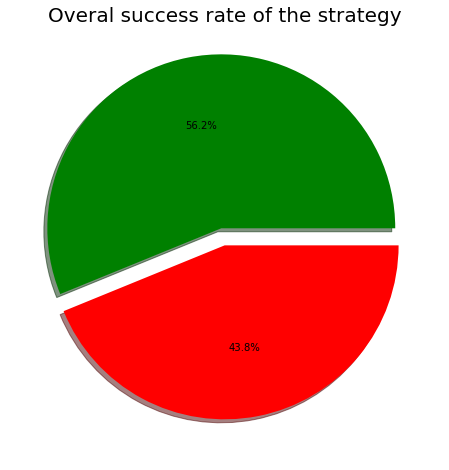

In [ ]:
fig, ax = plt.subplots(figsize=(8,8), facecolor="white")

ax.pie([data["gtrades"].sum(), data["trades"].sum()-data["gtrades"].sum()], colors=["g","r"], shadow=True, explode=(0.1, 0), autopct="%1.1f%%")
ax.set_title("Overal success rate of the strategy", fontsize=20)